# Denoising using Autoencoder

## Components
1. Enoder: Reduce the data into low dimension
2. Decoder: Takes an encoded version of input and regenerate the data in higher dimension
3. Bottleneck: Compressed version of data

# steps 
1. Prepare input data by adding noise to CIFAR10 dataset
2. Build a CNN Autoencoder Network
3. Train the network
4. Test the performance of Autoencoder

# Step 1: Prepare input data by adding noise to CIFAR10 dataset

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, Activation, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
import tensorflow as tf

Load the CIFAR10 dataset having shape of [32, 32, 3]. Rescale data to [0, 1] by dividing with 255.

## Adding noice

To add noise we can generate array with same dimension of our images with random values between `[0,1]` using normal distribution with mean = 0 and standard deviation = 0.3.

To generate normal distribution, we can use `np.random.normal(loc,scale,size)`. Then scale the noise by some factor, here I am using `0.3`. After adding noise, pixel values can be out of range `[0,1]`, so we need to clip the values using `np.clip(arr, arr_min, arr_max )`.

In [2]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

# scaling input data
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

def add_noise_and_clip_data(data):
    noise = np.random.normal(loc = 0.0, scale = 0.3, size = data.shape)
    data = data + noise * 0.3
    data = np.clip(data, 0., 1.)
    return data

train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

170500096/170498071 [==============================] - 3s 0us/step


## Visualise Noisy Images

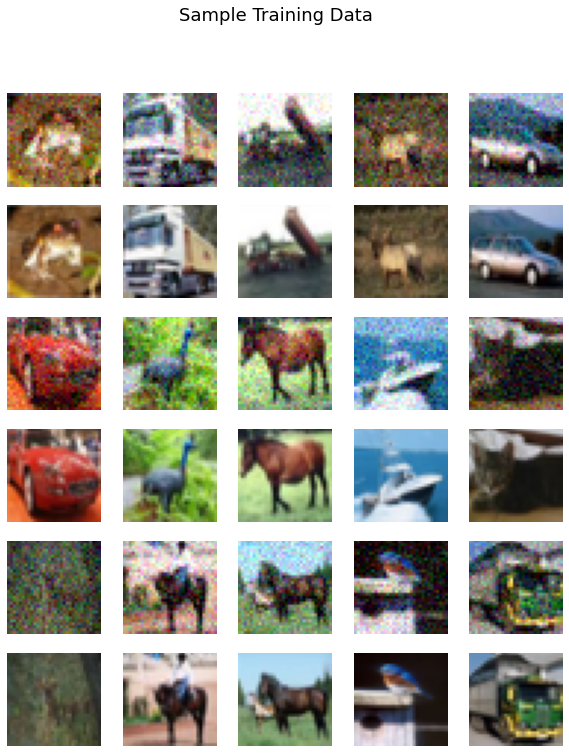

In [3]:
rows = 3 # defining no. of rows in figure
cols = 5 # defining no. of colums in figure

f = plt.figure(figsize = (2 * cols, 2 * rows * 2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(train_data_noisy[i * cols + j]) 
        plt.axis("off")
    
    for j in range(cols): 
        f.add_subplot(rows * 2, cols, ((2 * i + 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(train_data_clean[i * cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data", fontsize = 18)
plt.savefig("Cifar-trian.png")

plt.show()

# Step 2: Build a CNN Autoencoder Network

## Architecture

Convolutional blocks consist of 3 operations: 2D convolution, batch normalization and ReLu activation. We use strides=2 to downsample data going through the network.

Deconvolutional blocks also consist of 3 operations: 2D transposed convolution, batch normalization and also ReLu activation. Here strides=2 is used to upsample the data.

In [4]:
def conv_block(x, filters, kernel_size, strides = 2):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same',
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        padding = 'same',
                        activation = 'relu',
                        kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

- 5 convolutional blocks with downsampling
- 1 convolutional block without downsampling
- 5 deconvolutional blocks with upsampling, interleaving concatenations
- 1 final deconvolution that recreates image size (32, 32, 3)
- 1 activation layer with sigmoid that scales values to 0-1.

In [5]:
def autoencoder():
    inputs = Input(shape = (32, 32, 3), name = 'inputs')
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3)
    conv_block6 = conv_block(conv_block5, 512, 3, 1)
    
    deconv_block1 = deconv_block(conv_block6, 512, 3)
    merge1 = Concatenate()([deconv_block1, conv_block4])
    deconv_block2 = deconv_block(merge1, 256, 3)
    merge2 = Concatenate()([deconv_block2, conv_block3])
    deconv_block3 = deconv_block(merge2, 128, 3)
    merge3 = Concatenate()([deconv_block3, conv_block2])
    deconv_block4 = deconv_block(merge3, 64, 3)
    merge4 = Concatenate()([deconv_block4, conv_block1])
    deconv_block5 = deconv_block(merge4, 32, 3)
    
    final_deconv = Conv2DTranspose(filters = 3, kernel_size = 3, padding = 'same')(deconv_block5)
    outputs = Activation('sigmoid', name = 'output')(final_deconv)
    return Model(inputs, outputs, name = 'autoencoder')

In [6]:
model = autoencoder()

def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.80):
            print("\nReached 80% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True, save_weights_only = True)

model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     18496       batch_normalization[0][0]        
________________________________________________________________________________________

In [7]:
# Training
history = model.fit(train_data_noisy,
                    train_data_clean,
                    validation_data = (test_data_noisy, test_data_clean),
                    epochs = 25,
                    batch_size = 128,
                    shuffle = True,
                    callbacks = [checkpoint, callbacks, lr])

Epoch 1/25
391/391 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.5640
Epoch 00001: val_loss improved from inf to 0.10262, saving model to best_model.h5
391/391 [==============================] - 12s 31ms/step - loss: 0.6197 - accuracy: 0.5640 - val_loss: 0.1026 - val_accuracy: 0.5953 - lr: 1.0000e-04
Epoch 2/25
390/391 [============================>.] - ETA: 0s - loss: 0.0403 - accuracy: 0.7001
Epoch 00002: val_loss improved from 0.10262 to 0.02095, saving model to best_model.h5
391/391 [==============================] - 11s 28ms/step - loss: 0.0403 - accuracy: 0.7001 - val_loss: 0.0210 - val_accuracy: 0.7156 - lr: 1.0000e-04
Epoch 3/25
390/391 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.7459
Epoch 00003: val_loss improved from 0.02095 to 0.00975, saving model to best_model.h5
391/391 [==============================] - 11s 29ms/step - loss: 0.0118 - accuracy: 0.7459 - val_loss: 0.0098 - val_accuracy: 0.7452 - lr: 1.0000e-04
Epoch 4/

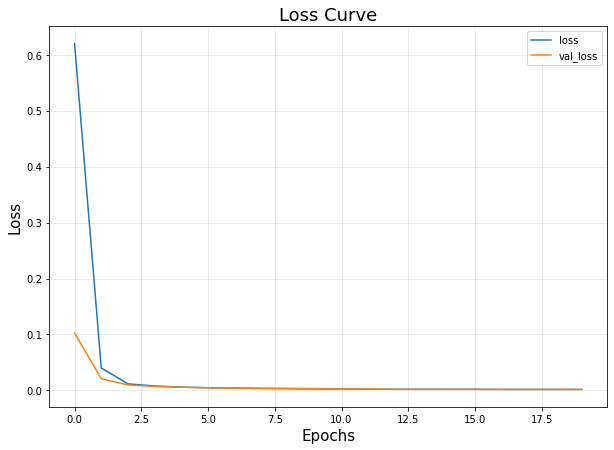

In [8]:
 # Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

# Step 4: Test the performance of Autoencoder

In [9]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, test_data_noisy.shape[0]-48) 

cifar_test_images = test_data_noisy[rand:rand+num_imgs] # slicing
cifar_test_predicted = model.predict(cifar_test_images) # predict

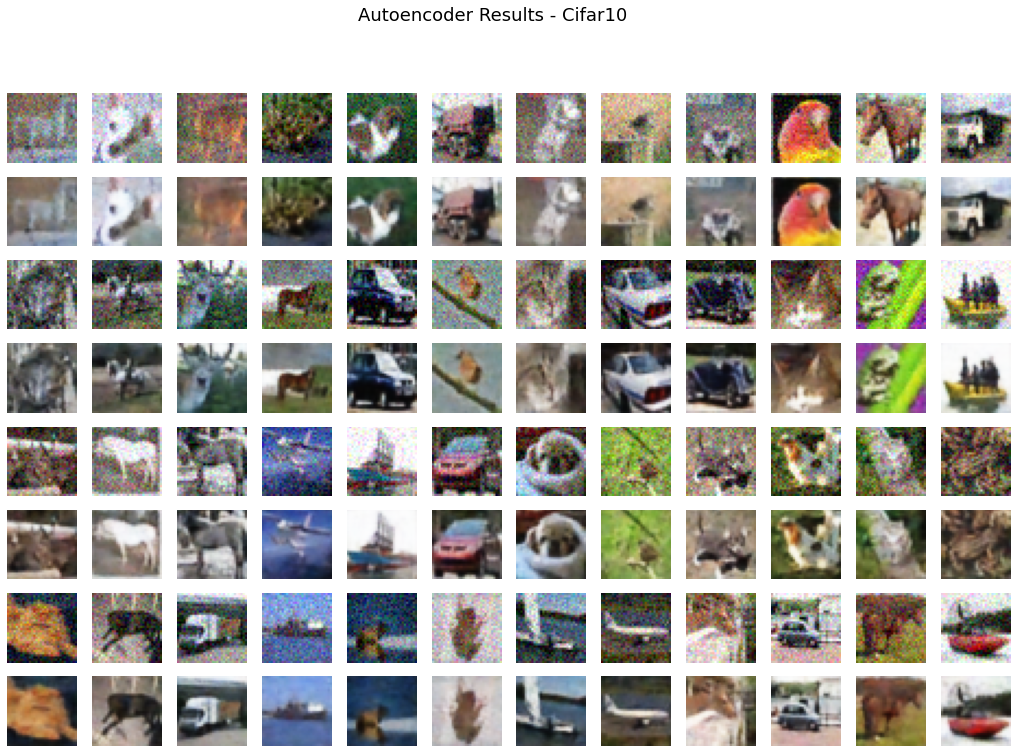

In [10]:
rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows * 2, cols, (2 * i * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i * cols + j]) 
        plt.axis("off")
    
    for j in range(cols): 
        f.add_subplot(rows * 2, cols, ((2 * i+ 1) * cols) + (j + 1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_predicted[i * cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()